### Step 1: Load macro time series

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Make plots inline
%matplotlib inline

In [2]:
# 1) Paths and basic setup
PROJECT_ROOT = Path("..").resolve()
MACRO_PATH   = PROJECT_ROOT / "data_work" / "macro_q.parquet"

print("Project root:", PROJECT_ROOT)
print("Macro file:", MACRO_PATH)


Project root: /Users/binodtandan/UNT Research/ai_stress_testing
Macro file: /Users/binodtandan/UNT Research/ai_stress_testing/data_work/macro_q.parquet


In [3]:
# 2) Load quarterly macro data (created by merge_macro.py)
#    Columns: quarter, quarter_start, GDPC1, UNRATE, CPIAUCSL, FEDFUNDS
macro = pd.read_parquet(MACRO_PATH)

# Sort by time just to be safe
macro = macro.sort_values("quarter_start").reset_index(drop=True)

# Set a proper datetime index for time-series work
macro = macro.set_index("quarter_start")

print("Macro shape:", macro.shape)
display(macro.head())

Macro shape: (48, 5)


,quarter,GDPC1,UNRATE,CPIAUCSL,FEDFUNDS
quarter_start,,,,,
2007-01-01,2007Q1,16611.690,4.500000,204.317000,5.256667
2007-04-01,2007Q2,16713.314,4.500000,206.631000,5.250000
2007-07-01,2007Q3,16809.587,4.666667,207.939000,5.073333
2007-10-01,2007Q4,16915.191,4.800000,210.489667,4.496667
2008-01-01,2008Q1,16843.003,5.000000,212.769667,3.176667


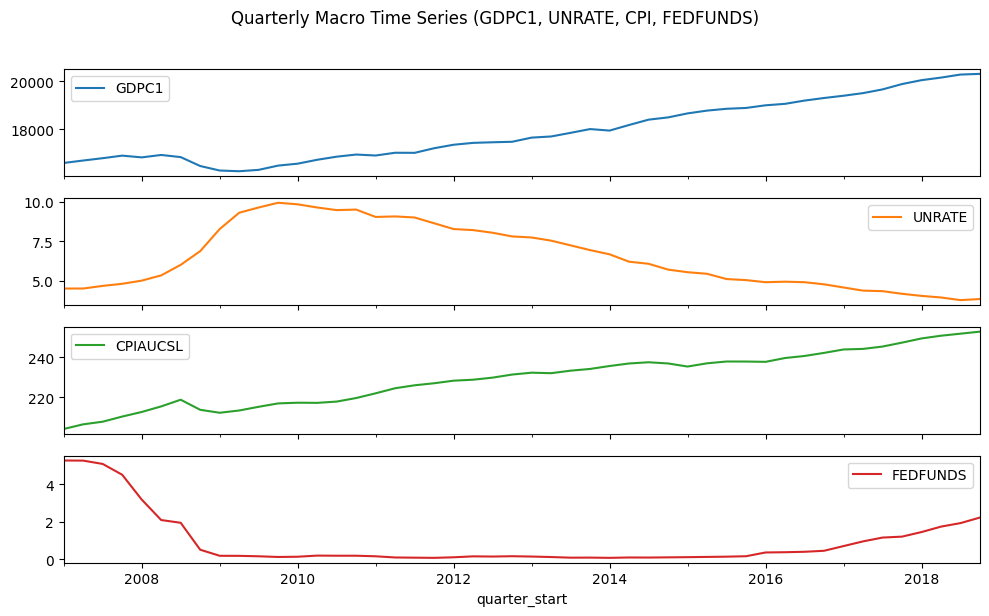

In [4]:
# Keep only the four macro variables we use in the PD model
macro_vars = ["GDPC1", "UNRATE", "CPIAUCSL", "FEDFUNDS"]
macro_ts = macro[macro_vars].copy()

# Quick sanity-check plot (optional, but helpful)
ax = macro_ts.plot(subplots=True, figsize=(10, 6), sharex=True)
plt.suptitle("Quarterly Macro Time Series (GDPC1, UNRATE, CPI, FEDFUNDS)", y=1.02)
plt.tight_layout()
plt.show()

### Step 2: Normalize macro series + build sliding windows

In [5]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# macro_ts should exist from Step 1 and contain:
# columns: ["GDPC1", "UNRATE", "CPIAUCSL", "FEDFUNDS"]

print("macro_ts shape:", macro_ts.shape)
display(macro_ts.head())

macro_ts shape: (48, 4)


,GDPC1,UNRATE,CPIAUCSL,FEDFUNDS
quarter_start,,,,
2007-01-01,16611.690,4.500000,204.317000,5.256667
2007-04-01,16713.314,4.500000,206.631000,5.250000
2007-07-01,16809.587,4.666667,207.939000,5.073333
2007-10-01,16915.191,4.800000,210.489667,4.496667
2008-01-01,16843.003,5.000000,212.769667,3.176667


In [6]:
# 2.1 Normalize the macro variables
#     We use StandardScaler: (x - mean) / std per variable.
scaler = StandardScaler()
macro_scaled = scaler.fit_transform(macro_ts.values)

macro_scaled_df = pd.DataFrame(
    macro_scaled,
    index=macro_ts.index,
    columns=macro_ts.columns
)

print("Scaled macro (first rows):")
display(macro_scaled_df.head())

Scaled macro (first rows):


,GDPC1,UNRATE,CPIAUCSL,FEDFUNDS
quarter_start,,,,
2007-01-01,-1.065302,-1.014786,-1.924282,3.036758
2007-04-01,-0.982338,-1.014786,-1.746667,3.032086
2007-07-01,-0.903742,-0.931035,-1.646269,2.908277
2007-10-01,-0.817529,-0.864034,-1.450489,2.504149
2008-01-01,-0.876462,-0.763532,-1.275484,1.579091


In [7]:
# 2.2 Build sliding windows of length T (sequence length)
#     Each sample is a T x 4 matrix:
#       [ [GDPC1_t, UNRATE_t, CPI_t, FEDFUNDS_t],
#         [GDPC1_{t+1}, ...],
#         ...
#         [GDPC1_{t+T-1}, ...] ]
#
#     This will be the input to the VAE: X_seq with shape (n_samples, T, 4)
# ---------------------------------------------------------------------
WINDOW_SIZE = 8  # 8 quarters (~2 years); you can change to 4, 12, etc.

def build_windows(arr: np.ndarray, window_size: int):
    """
    arr: numpy array of shape (n_timesteps, n_features)
    returns: array of shape (n_samples, window_size, n_features)
    """
    n, d = arr.shape
    if n < window_size:
        raise ValueError(f"Not enough time steps ({n}) for window_size={window_size}")
    windows = []
    end_indices = []  # keep which quarter each window ends at (for reference)
    for start in range(0, n - window_size + 1):
        end = start + window_size
        windows.append(arr[start:end, :])
        end_indices.append(macro_ts.index[end - 1])
    return np.stack(windows), np.array(end_indices)

X_seq, window_ends = build_windows(macro_scaled, WINDOW_SIZE)

print("X_seq shape (n_samples, T, n_features):", X_seq.shape)
print("First 5 window end quarters:", window_ends[:5])

X_seq shape (n_samples, T, n_features): (41, 8, 4)
First 5 window end quarters: [Timestamp('2008-10-01 00:00:00') Timestamp('2009-01-01 00:00:00')
 Timestamp('2009-04-01 00:00:00') Timestamp('2009-07-01 00:00:00')
 Timestamp('2009-10-01 00:00:00')]


### Step 3: Define and train a simple VAE on macro sequences

In [8]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# 3.1 Prepare data for PyTorch (flatten sequences)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

n_samples, T, D = X_seq.shape  # D=4 macro vars
input_dim = T * D              # flatten time + features
latent_dim = 2                 # small latent space (easy to interpret)

X_flat = X_seq.reshape(n_samples, input_dim)
X_tensor = torch.tensor(X_flat, dtype=torch.float32)

dataset = TensorDataset(X_tensor)
batch_size = 16
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Using device: cpu


In [9]:
# 3.2 Define a small MLP VAE
class MacroVAE(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int, hidden_dim: int = 64):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.mu_layer     = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

vae = MacroVAE(input_dim=input_dim, latent_dim=latent_dim, hidden_dim=64).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [11]:
# 3.3 VAE loss: reconstruction (MSE) + KL divergence

def vae_loss_fn(recon_x, x, mu, logvar):
    # Reconstruction loss (mean squared error)
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction="sum")
    # KL divergence between q(z|x) and N(0, I)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl, recon_loss, kl


In [12]:
# 3.4 Training loop

n_epochs = 300
print_every = 20

vae.train()
for epoch in range(1, n_epochs + 1):
    total_loss = 0.0
    total_recon = 0.0
    total_kl = 0.0
    n_points = 0

    for (batch_x,) in loader:
        batch_x = batch_x.to(device)

        optimizer.zero_grad()
        recon, mu, logvar = vae(batch_x)
        loss, recon_loss, kl_loss = vae_loss_fn(recon, batch_x, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss  += loss.item()
        total_recon += recon_loss.item()
        total_kl    += kl_loss.item()
        n_points    += batch_x.size(0)

    if epoch % print_every == 0 or epoch == 1 or epoch == n_epochs:
        avg_loss  = total_loss  / n_points
        avg_recon = total_recon / n_points
        avg_kl    = total_kl    / n_points
        print(f"Epoch {epoch:3d}/{n_epochs} | "
              f"Loss: {avg_loss:.4f}  Recon: {avg_recon:.4f}  KL: {avg_kl:.4f}")

print("VAE training complete.")


Epoch   1/300 | Loss: 24.3895  Recon: 24.3697  KL: 0.0198
Epoch  20/300 | Loss: 10.6810  Recon: 8.8586  KL: 1.8223
Epoch  40/300 | Loss: 6.2002  Recon: 3.5419  KL: 2.6583
Epoch  60/300 | Loss: 4.4228  Recon: 1.9453  KL: 2.4775
Epoch  80/300 | Loss: 4.1909  Recon: 1.5443  KL: 2.6466
Epoch 100/300 | Loss: 4.3632  Recon: 1.8869  KL: 2.4762
Epoch 120/300 | Loss: 3.8845  Recon: 1.3578  KL: 2.5267
Epoch 140/300 | Loss: 3.8643  Recon: 1.4752  KL: 2.3891
Epoch 160/300 | Loss: 3.8362  Recon: 1.1005  KL: 2.7357
Epoch 180/300 | Loss: 3.1426  Recon: 0.7261  KL: 2.4166
Epoch 200/300 | Loss: 3.6091  Recon: 1.1732  KL: 2.4359
Epoch 220/300 | Loss: 3.4458  Recon: 1.0535  KL: 2.3923
Epoch 240/300 | Loss: 3.1338  Recon: 0.7975  KL: 2.3363
Epoch 260/300 | Loss: 3.3356  Recon: 0.9356  KL: 2.4000
Epoch 280/300 | Loss: 3.3847  Recon: 0.9859  KL: 2.3988
Epoch 300/300 | Loss: 3.5002  Recon: 1.1266  KL: 2.3736
VAE training complete.


### Step 4: Sample synthetic macro paths and build GenAI scenarios

In [13]:
vae.eval()

macro_cols = ["GDPC1", "UNRATE", "CPIAUCSL", "FEDFUNDS"]
delta_cols = ["UNRATE_delta_qoq", "FEDFUNDS_delta_qoq",
              "GDPC1_delta_qoq", "inflation_qoq", "real_rate_qoq"]

In [14]:
# 4.1 Sample synthetic sequences from latent space

n_samples_gen = 200  # number of synthetic paths to generate
latent_dim = 2       # must match what you used in VAE definition
T = WINDOW_SIZE
D = len(macro_cols)

synthetic_paths = []

with torch.no_grad():
    for i in range(n_samples_gen):
        # Sample z ~ N(0, I)
        z = torch.randn(1, latent_dim).to(device)
        recon_flat = vae.decode(z)              # shape (1, input_dim)
        recon_flat = recon_flat.cpu().numpy()
        recon_seq = recon_flat.reshape(T, D)    # (T, 4) in scaled space

        # Unscale back to original macro space using the fitted scaler
        recon_unscaled = scaler.inverse_transform(recon_seq)
        synthetic_paths.append(recon_unscaled)

synthetic_paths = np.stack(synthetic_paths)  # shape: (n_samples_gen, T, 4)
print("Synthetic paths shape:", synthetic_paths.shape)

Synthetic paths shape: (200, 8, 4)


In [15]:
# 4.2 Define a severity score for each synthetic path
#     Idea: high UNRATE + low GDP growth = more severe.
#     We compute a simple scalar:
#         severity = max(UNRATE) - min(GDPC1)

def compute_severity(path, macro_cols):
    """
    path: array of shape (T, 4) with columns [GDPC1, UNRATE, CPIAUCSL, FEDFUNDS]
    returns: scalar severity score
    """
    # convert to DataFrame for readability
    df_p = pd.DataFrame(path, columns=macro_cols)
    unrate_max = df_p["UNRATE"].max()
    gdp_min = df_p["GDPC1"].min()
    severity = unrate_max - gdp_min
    return severity, df_p

severity_records = []

for i in range(synthetic_paths.shape[0]):
    path = synthetic_paths[i]
    sev, df_p = compute_severity(path, macro_cols)
    severity_records.append({"idx": i, "severity": sev})

severity_df = pd.DataFrame(severity_records).sort_values("severity").reset_index(drop=True)
display(severity_df.head())
display(severity_df.tail())


,idx,severity
0,83,-19720.912109
1,163,-19364.220703
2,179,-19363.595703
3,173,-19330.035156
4,182,-19303.064453


,idx,severity
195,169,-16051.312500
196,195,-16028.308594
197,36,-15975.749023
198,38,-15781.557617
199,84,-15746.379883


In [16]:
# 4.3 Choose representative GenAI scenarios by severity percentile

def pick_by_percentile(severity_df, percentile):
    """
    Pick index of synthetic path at given percentile of severity.
    """
    rank = int(len(severity_df) * percentile)
    rank = max(0, min(len(severity_df) - 1, rank))
    row = severity_df.iloc[rank]
    return int(row["idx"]), float(row["severity"])

idx_mild, sev_mild     = pick_by_percentile(severity_df, 0.55)
idx_adverse, sev_adv   = pick_by_percentile(severity_df, 0.80)
idx_severe, sev_severe = pick_by_percentile(severity_df, 0.95)

print("GenAI_Mild   -> idx:", idx_mild,   "severity:", sev_mild)
print("GenAI_Adverse-> idx:", idx_adverse,"severity:", sev_adv)
print("GenAI_Severe -> idx:", idx_severe, "severity:", sev_severe)

genai_paths = {
    "GenAI_Mild":   synthetic_paths[idx_mild],
    "GenAI_Adverse": synthetic_paths[idx_adverse],
    "GenAI_Severe": synthetic_paths[idx_severe],
}


GenAI_Mild   -> idx: 104 severity: -17269.5390625
GenAI_Adverse-> idx: 55 severity: -16659.24609375
GenAI_Severe -> idx: 149 severity: -16205.478515625


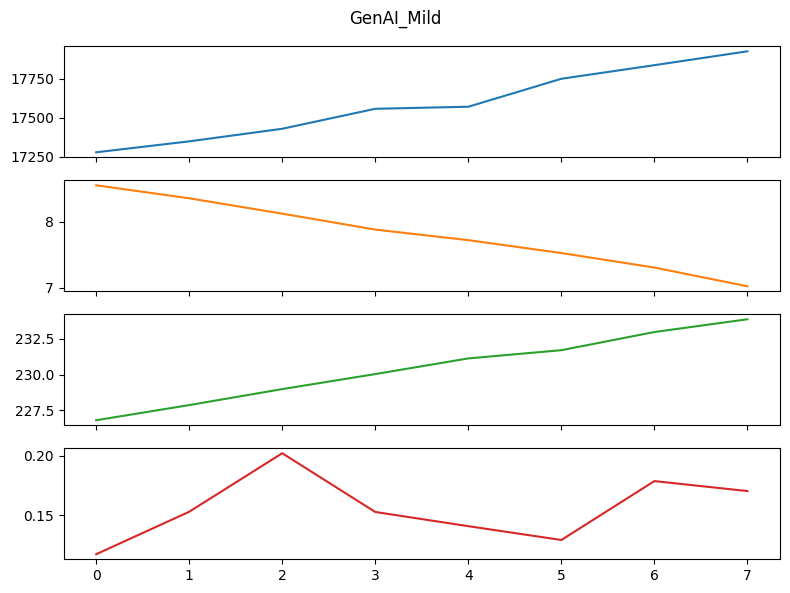

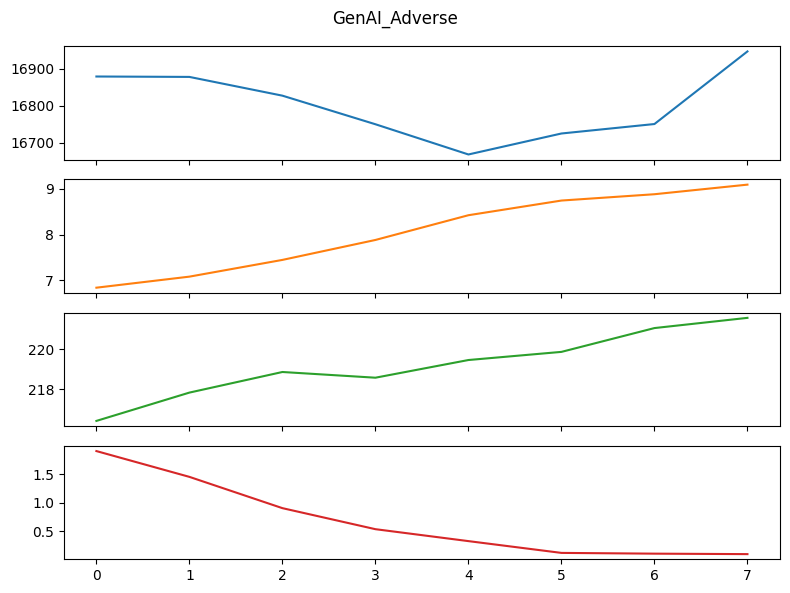

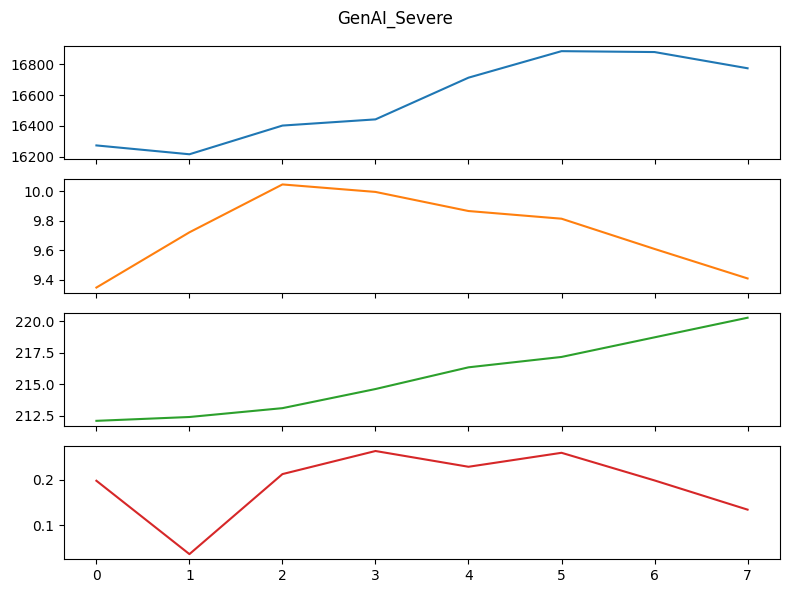

In [17]:
for name, path in genai_paths.items():
    df_p = pd.DataFrame(path, columns=macro_cols)
    df_p.plot(subplots=True, figsize=(8, 6), title=name, legend=False)
    plt.tight_layout()
    plt.show()


In [18]:
# 4.4 Convert GenAI paths into single-quarter stress scenarios

def path_to_scenario(name: str, path: np.ndarray, macro_cols: list) -> dict:
    """
    path: (T, 4) unscaled macro sequence
    returns: dict with macro levels + delta features
    """
    df_p = pd.DataFrame(path, columns=macro_cols).reset_index(drop=True)
    
    # 1) Pick the "worst" quarter: max UNRATE
    worst_idx = int(df_p["UNRATE"].idxmax())
    
    # Ensure we have a previous quarter for deltas; if worst_idx == 0, shift to 1
    if worst_idx == 0 and len(df_p) > 1:
        worst_idx = 1

    # Current quarter values
    row_curr = df_p.iloc[worst_idx]
    
    # Previous quarter (for deltas)
    if worst_idx > 0:
        row_prev = df_p.iloc[worst_idx - 1]
    else:
        row_prev = row_curr  # fallback, no delta

    scen = {"scenario": name}

    # Macro levels
    for col in macro_cols:
        scen[col] = float(row_curr[col])

    # Deltas (simple percentage change)
    scen["UNRATE_delta_qoq"]   = (row_curr["UNRATE"]   - row_prev["UNRATE"])   / max(abs(row_prev["UNRATE"]), 1e-6)
    scen["GDPC1_delta_qoq"]    = (row_curr["GDPC1"]    - row_prev["GDPC1"])    / max(abs(row_prev["GDPC1"]), 1e-6)
    scen["FEDFUNDS_delta_qoq"] = (row_curr["FEDFUNDS"] - row_prev["FEDFUNDS"]) / max(abs(row_prev["FEDFUNDS"]), 1e-6)
    scen["inflation_qoq"]      = (row_curr["CPIAUCSL"] - row_prev["CPIAUCSL"]) / max(abs(row_prev["CPIAUCSL"]), 1e-6)

    scen["real_rate_qoq"] = scen["FEDFUNDS_delta_qoq"] - scen["inflation_qoq"]

    return scen




In [19]:
genai_scenarios = []
for name, path in genai_paths.items():
    scen = path_to_scenario(name, path, macro_cols)
    genai_scenarios.append(scen)

genai_scenarios_df = pd.DataFrame(genai_scenarios)
display(genai_scenarios_df)

,scenario,GDPC1,UNRATE,CPIAUCSL,FEDFUNDS,UNRATE_delta_qoq,GDPC1_delta_qoq,FEDFUNDS_delta_qoq,inflation_qoq,real_rate_qoq
0,GenAI_Mild,17348.369141,8.350855,227.873260,0.153083,-0.022985,0.004068,0.304628,0.004659,0.299969
1,GenAI_Adverse,16946.115234,9.092122,221.578384,0.098080,0.023628,0.011685,-0.077602,0.002321,-0.079922
2,GenAI_Severe,16402.316406,10.046570,213.093597,0.212905,0.033472,0.011519,4.853404,0.003310,4.850093


In [20]:

PROJECT_ROOT = Path("..").resolve()
RES_DIR = PROJECT_ROOT / "results"
RES_DIR.mkdir(exist_ok=True, parents=True)

out_path = RES_DIR / "genai_scenarios.csv"
genai_scenarios_df.to_csv(out_path, index=False)
print("Saved GenAI scenarios to:", out_path)

Saved GenAI scenarios to: /Users/binodtandan/UNT Research/ai_stress_testing/results/genai_scenarios.csv
